# Simulation Setup

In [1]:
import numpy as np


p = 1000 # Number of dimensions
c = 1 # Target meanshift is c * M
k = 50 # Number of failuer Mode
seed_list_OC = 20 # Seed of data generation
sel_failure_mode = [10,20,30]    #  Failure Mode
M = np.kron(np.eye(k),np.ones((int(p/k),1))) # Mean Failure Modes
Ks = 3  #Select Top Ks control chart
nsensors = 5 # Number of selected sensors
ARL0 = 200 # Target ARL-IC
Tmax = 500 # Maximum length


## Data generation Function
Data are generated as i.i.d normal before change. 
After change, add certain failure mode on the data.

In [2]:
def data_gen_func0(n_batch, Tmax, seed):
    # Generate normal samples
    np.random.seed(seed)    
    data = np.random.randn(n_batch,Tmax,p)
    return data

def data_gen_func1(n_batch, Tmax, seed, T0, delta):
    # Generate abnormal samples
    np.random.seed(seed)
    D1 = np.random.randn(n_batch, Tmax, p)
    shift = np.sum(M[:,sel_failure_mode]*delta,1)
    for i in range(T0,Tmax):
        for j in range(n_batch):
            D1[j,i,:] = D1[j,i,:]+shift
    return D1




## Failure Mode Visualization

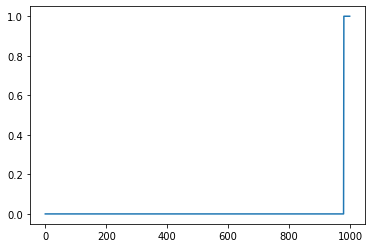

In [3]:
import matplotlib.pyplot as plt
#_ = plt.plot(M)
plt.plot(M[:,49])

In [4]:
from ExtendedTSSRP import ExtendedTSSRP
from TSSRP import TSSRP
from Oracle import Oracle
from spc import spc
truesensidx = np.arange(nsensors)
nmodels = 8
model_all = [[] for i in range(nmodels)]

# p, c, k, M, nsensors, Ks, L=-1, chart = 'srp',mode = 'T2'
    
model_all[0] = ExtendedTSSRP(p, c, k,M,nsensors,Ks,L=-1,chart = 'srp',mode='T2')
model_all[1] = ExtendedTSSRP(p, c, k,M,nsensors,Ks,L=-1,chart = 'cusum')
model_all[2] = ExtendedTSSRP(p, c, k, M, nsensors, Ks, L=-1, chart = 'srp',mode='T1')
model_all[3] = ExtendedTSSRP(p, c, k, M, nsensors, Ks, L=-1, chart = 'srp',mode='T2',sample_mode = 'mean')
model_all[4] = ExtendedTSSRP(p, c, k, M, nsensors, Ks, L=-1, chart = 'cusum',sample_mode = 'mean')
model_all[5] = TSSRP(p, c, k,M,nsensors,Ks,L=-1,chart='srp',mode='T2')
model_all[6] = TSSRP(p, c, k,M,nsensors,Ks,L=-1,chart='cusum',mode='T2')
model_all[7] = Oracle(truesensidx, p, c, k, M, nsensors, Ks, L=-1, chart = 'srp',mode='T2')

model_name = ['E_srp_T2','E_cusum','E_srp_T1','E_srp_T2_mean','E_cusum_mean','srp_T2','cumsum','oracle']
#experiment_log['model_name'] = model_name

# Result Visualization

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
T0 = 100
Tmax = 200
delta = 1
x = data_gen_func1(3, Tmax, seed_list_OC, T0, delta)

imodel = 0
model = model_all[imodel]

sequential_statistics_topRsum, sensor_selection_history, failure_mode_history, i,sequential_statistics= model.compute_monitoring_statistics(x[0],T0,-1)

## Control Chart
The control chart starts to increase around time 100, which is the time of change.

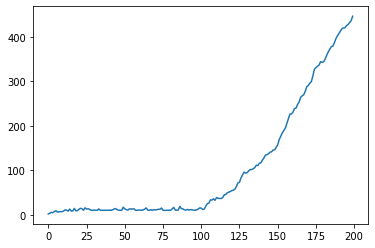

In [6]:
import matplotlib.pyplot as plt
plt.plot(sequential_statistics_topRsum)

## Failure Mode SRP statistics
The statistics of three failure modes are very clear to accumulate

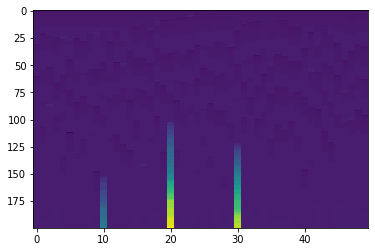

In [7]:
plt.imshow(sequential_statistics,aspect='auto')

## Look into each SRP statistics for different failure mode


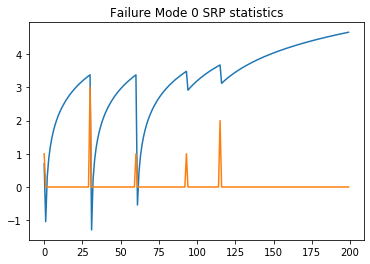

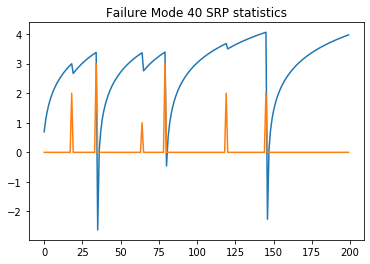

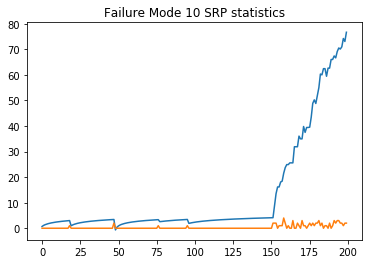

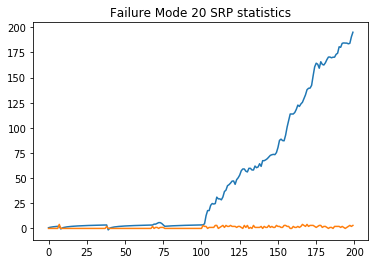

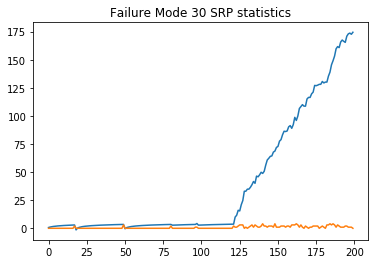

In [8]:
for plotfailuremode in [0,40,10,20,30]:
    arr = np.array([plotfailuremode in i for i in sensor_selection_history])
    plt.figure()    
    plt.plot(sequential_statistics[:,plotfailuremode],label='SRP statistics')
    mode = (sensor_selection_history/(p/k)).astype(int)
    numSensorInFailureMode = np.zeros(Tmax)
    for ii,i in enumerate(mode):
        numSensorInFailureMode[ii] = np.sum([j ==plotfailuremode for j in i])
    plt.title('Failure Mode {} SRP statistics'.format(plotfailuremode))
    _ = plt.plot(numSensorInFailureMode,label = '# of Observed Sensors')

## Number of observed sensors in the failure mode
The number of observed sensor in different failure mode increases when we passes 100. 

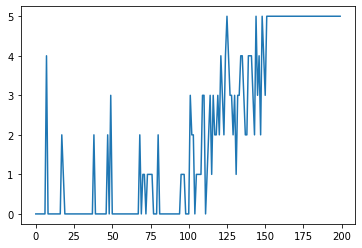

In [298]:
ii = 0
mode = (sensor_selection_history/(p/k)).astype(int)
numSensorInFailureMode = np.zeros(Tmax)
for ii,i in enumerate(mode):
    numSensorInFailureMode[ii] = np.sum([j in sel_failure_mode for j in i])
plt.plot(numSensorInFailureMode)

In [299]:
sensor_selection_history/50

array([[10.82,  0.3 , 11.48, 10.94, 11.06],
       [ 9.84, 10.4 ,  9.78,  9.68, 11.8 ],
       [19.48, 10.58, 19.66, 10.52, 10.46],
       [18.32, 10.3 ,  9.22, 10.  , 10.22],
       [19.08,  9.42, 18.22, 18.3 , 18.1 ],
       [ 9.56, 19.08, 19.16,  8.84,  9.  ],
       [16.88,  8.72, 18.7 , 18.46,  8.54],
       [ 8.28,  8.22,  8.02, 17.02,  8.26],
       [ 7.6 , 14.64, 14.92,  7.84, 14.86],
       [13.58, 13.3 ,  7.56, 13.28, 13.76],
       [ 7.36, 12.98,  7.34, 12.8 ,  7.28],
       [ 7.28,  6.46,  6.74, 12.74,  7.58],
       [ 6.62, 12.74,  6.76, 12.72, 12.48],
       [ 7.3 ,  6.22, 15.58,  6.12,  6.08],
       [15.52,  6.28,  7.48,  7.34, 15.34],
       [15.96, 15.86, 14.16, 14.12,  5.68],
       [17.44,  4.8 ,  5.  ,  6.84, 17.3 ],
       [ 6.8 ,  6.92, 12.26,  5.04, 12.36],
       [16.46,  4.  , 16.18, 16.06, 16.64],
       [16.72, 16.58, 16.42,  3.68,  3.6 ],
       [ 3.68,  0.48,  1.16,  1.04,  1.18],
       [ 3.8 ,  3.2 ,  3.82,  1.08,  1.  ],
       [17.88,  3.82, 17.7 , 17.

## Top-R Failure Mode visualization



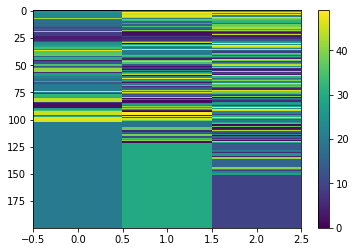

In [300]:
plt.imshow(failure_mode_history,aspect='auto')
plt.colorbar()

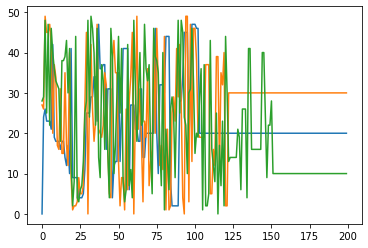

In [301]:
_ = plt.plot(failure_mode_history[:,:3])

## ARL results
ARL shows four methods:
- Extended TSSRP baed on sampled version of statistics (E_srp_sample)
- Extended TSSRP baed on mean version of statistics (E_srp_mean)
- Naive implementation of Extended TS CUSUM (E_cusum)
- TSSRP method (srp_T2)

Results show that E_cusum would not work since it doesn't encourage exploration at all. 
TSSRP does not use failure mode information and the result is much worse. 
sampled version of ETSSRP has the advantage over non-sampled version especially when meanshift is small

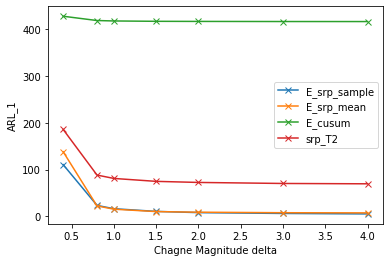

In [253]:
import numpy as np
import pickle
# delta_all =  [0,0.1,0.2,0.3,0.4,0.5,0.6,0.8,1,1.2,1.5,1.8,2,3,4]
delta_all =  [0.4,0.8,1,1.5,2,3,4]
model_name = ['E_srp_sample','E_srp_mean','E_cusum','srp_T2']
experiment_log = pickle.load( open( "2020Mar28_1020_exp.pickle", "rb" ) )
ARL_all_new = experiment_log['ARL1']

#ARL_5 = pickle.load( open( "ARL_5.pickle", "rb" ) )
#ARL_67 = pickle.load( open( "ARL_67.pickle", "rb" ) )
#ARL_all_new = np.concatenate((ARL_all,ARL_5[[5],:]),0)
#ARL_all_new = np.concatenate((ARL_all_new,ARL_67[[6,7],:]),0)
nmodels = 4
import matplotlib.pyplot as plt
%matplotlib inline
for i in [0,1,2,3]:
    plt.plot(delta_all,ARL_all_new[i,:],'x-',label=model_name[i])
    plt.xlabel('Chagne Magnitude delta')
    plt.ylabel('ARL_1')
    plt.legend()